<a href="https://colab.research.google.com/github/mohamed-mkh15/ML2023_Project_Team34_VectorMapNetImplementation/blob/main/HDMap_merge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mmcv

In [ ]:
import mmcv
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#results = mmcv.load("submission_vector.pkl")
results_pd = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/submission_vector.pkl")  

In [4]:
GlobalMap = pd.DataFrame(results_pd) 
GlobalMap

,meta,results
use_lidar,False,NaN
use_camera,True,NaN
use_radar,False,NaN
use_external,False,NaN
output_format,vector,NaN
...,...,...
e6e877f31dd447199b56cae07f86daad,NaN,"{'vectors': [[[-25.94974874 14.73737374], [-1..."
cb4e6195faad467094fbd4d0a9e960e9,NaN,"{'vectors': [[[-30. 12.7979798], [2.09..."
7f594234e8034228b1a7d727f1981e09,NaN,"{'vectors': [[[-13.48743719 14.73737374], [-9..."
9cdbf5ff7f294549aea0a4307e5d104a,NaN,"{'vectors': [[[-8.81407035 14.73737374], [-9.4..."


In [ ]:
GlobalMap.iloc[5, :].results

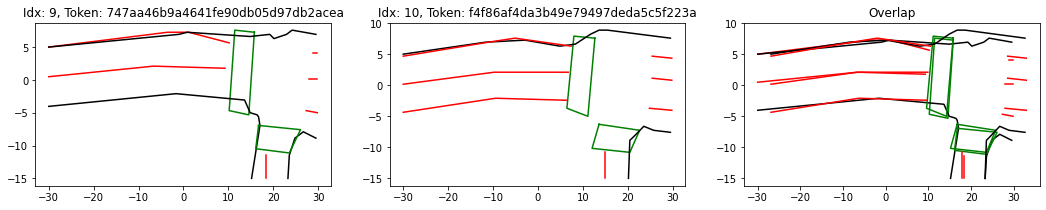

In [7]:
# Plot two instances of created HD maps and show their overlap
threshold = 0.8
idx_2_merge = [9,10]
x_shift = 3.1
y_shift = 0

fig, axs = plt.subplots(1, len(idx_2_merge)+1, figsize=(18, 3))
xs = 0
ys = 0
for ax, token_id in zip(axs, idx_2_merge):
    token_ex = GlobalMap.iloc[token_id, :].results
    for i in range(len(token_ex['vectors'])):
        if token_ex['scores'][i] >= threshold:
            x_values = token_ex['vectors'][i][:,0]
            y_values = token_ex['vectors'][i][:,1]

            if token_ex['labels'][i] == 0:
                color = 'g'
                label = 'ped_crossing'
            elif token_ex['labels'][i] == 1:
                color = 'r'
                label = 'divider'
            else: 
                color = 'k'
                label = 'boundary'
            ax.plot(x_values, y_values, color=color, label=label)
            ax.set_title('Idx: %i'%token_id + ', Token: %s' %GlobalMap.index[token_id])

            axs[-1].plot(x_values+xs, y_values+ys, color=color, label=label)
            axs[-1].set_title('Overlap')

        else: pass    
    xs+= x_shift
    ys+= y_shift
plt.show()

In [8]:
import numpy as np
from scipy.spatial import ConvexHull

def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.

    :param points: an nx2 matrix of coordinates
    :rval: an nx2 matrix of coordinates
    """
    from scipy.ndimage.interpolation import rotate
    pi2 = np.pi/2.

    # get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # calculate edge angles
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])

    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # find rotation matrices
    # XXX both work
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles-pi2),
        np.cos(angles+pi2),
        np.cos(angles)]).T
#     rotations = np.vstack([
#         np.cos(angles),
#         -np.sin(angles),
#         np.sin(angles),
#         np.cos(angles)]).T
    rotations = rotations.reshape((-1, 2, 2))

    # apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval

In [9]:
## def function to blot Bounding Box around set of 2d points
def plot_BB(A):
    plt.scatter(A[:,0], A[:,1])
    bbox = minimum_bounding_rectangle(A)
    plt.fill(bbox[:,0], bbox[:,1], alpha=0.2)
    plt.axis('equal')

# def function to check if points form a straight line or not
def notLine_check(points):
      (x0, y0), (x1, y1) = points[0], points[1]
      for i in range(2, len(points)):
         x, y = points[i]
         if (x0 - x1) * (y1 - y) != (x1 - x) * (y0 - y1):
            return True
      return False

<ipython-input-49-6670d0890c6f>:12: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


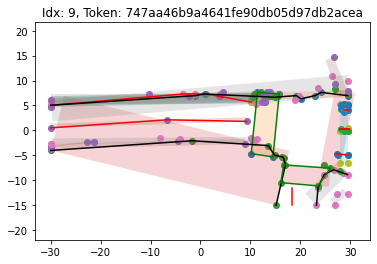

In [85]:
## Now try to plot min BB for each element for one instance
threshold = 0.8
token_id = 9

token_ex = GlobalMap.iloc[token_id, :].results
for i in range(len(token_ex['vectors'])):
    if token_ex['scores'][i] >= threshold:
        x_values = token_ex['vectors'][i][:,0]
        y_values = token_ex['vectors'][i][:,1]

        if token_ex['labels'][i] == 0:
            color = 'g'
            label = 'ped_crossing'
        elif token_ex['labels'][i] == 1:
            color = 'r'
            label = 'divider'
        else: 
            color = 'k'
            label = 'boundary'
    plt.plot(x_values, y_values, color=color, label=label)
    plt.title('Idx: %i'%token_id + ', Token: %s' %GlobalMap.index[token_id])
    if len(token_ex['vectors'][i]) > 2 and notLine_check(token_ex['vectors'][i]):
        plot_BB(token_ex['vectors'][i])

In [17]:
# now try to fix alignment problem (if boundary and divider align, remove the divider)
threshold = 0.8
token_id = 9
prox_th = 10 #proximity thrshold between centers of Bounding boxes

token_ex = GlobalMap.iloc[token_id, :].results
token_pd = pd.DataFrame.from_dict(token_ex)
token_pd['cx'] = token_pd['cy'] = np.zeros(len(token_pd['vectors']))


for i in range(len(token_pd['vectors'])):
    points = token_pd['vectors'][i]
    if token_pd['scores'][i] < threshold:
        token_pd.drop(i, inplace=True)

In [18]:
token_pd

,vectors,scores,labels,cx,cy
0,"[[15.798994974874368, 7.3030303030303045], [11...",0.999999,0,0.0,0.0
1,"[[15.175879396984925, -15.0], [17.045226130653...",0.999999,2,0.0,0.0
2,"[[-30.0, 0.5151515151515156], [-6.633165829145...",0.999995,1,0.0,0.0
3,"[[18.291457286432163, -11.444444444444445], [1...",0.999990,1,0.0,0.0
4,"[[29.507537688442213, -8.858585858585858], [28...",0.999965,2,0.0,0.0
5,"[[-30.0, 5.0404040404040416], [-3.517587939698...",0.999679,1,0.0,0.0
6,"[[28.884422110552762, 4.070707070707069], [29....",0.998924,1,0.0,0.0
7,"[[-30.0, 5.0404040404040416], [-1.025125628140...",0.991158,2,0.0,0.0
8,"[[16.733668341708544, -6.919191919191919], [16...",0.988573,0,0.0,0.0
9,"[[27.326633165829143, -4.656565656565656], [29...",0.976733,1,0.0,0.0


In [ ]:
for i in range(len(token_pd.index)):
    points = token_pd['vectors'][i]
    if len(points) > 2 and notLine_check(points):
        #plot_BB(token_ex['vectors'][i])
        bbox = minimum_bounding_rectangle(points)
        token_pd['cx'][i] = sum(bbox[:,0]) / len(bbox)
        token_pd['cy'][i]= sum(bbox[:,1]) / len(bbox)
    else:
        token_pd['cx'][i] = sum(points[:,0]) / len(points) 
        token_pd['cy'][i] = sum(points[:,1]) / len(points)

In [23]:
token_pd

,vectors,scores,labels,cx,cy
0,"[[15.798994974874368, 7.3030303030303045], [11...",0.999999,0,12.984438,1.216645
1,"[[15.175879396984925, -15.0], [17.045226130653...",0.999999,2,-6.082158,-4.038258
2,"[[-30.0, 0.5151515151515156], [-6.633165829145...",0.999995,1,-10.385785,1.584438
3,"[[18.291457286432163, -11.444444444444445], [1...",0.999990,1,18.291457,-13.222222
4,"[[29.507537688442213, -8.858585858585858], [28...",0.999965,2,25.240566,-10.761074
5,"[[-30.0, 5.0404040404040416], [-3.517587939698...",0.999679,1,-9.919290,6.281729
6,"[[28.884422110552762, 4.070707070707069], [29....",0.998924,1,29.351759,4.070707
7,"[[-30.0, 5.0404040404040416], [-1.025125628140...",0.991158,2,-0.259910,6.540773
8,"[[16.733668341708544, -6.919191919191919], [16...",0.988573,0,21.095477,-9.020202
9,"[[27.326633165829143, -4.656565656565656], [29...",0.976733,1,28.572864,-4.818182


In [26]:
len(token_pd.index)

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='int64')

# **Just Extra trials**

In [ ]:
# Extra.. for loop for showing min BB on random points
import matplotlib.pyplot as plt
for n in range(10):
    points = np.random.rand(4,2)
    plt.scatter(points[:,0], points[:,1])
    bbox = minimum_bounding_rectangle(points)
    plt.fill(bbox[:,0], bbox[:,1], alpha=0.2)
    plt.axis('equal')
    plt.show()

# Extra.. another mothod for calculating BB
#pip install git+https://github.com/ulikoehler/UliEngineering.git
from UliEngineering.Math.Coordinates import BoundingBox
# Usage example:
BoundingBox(token_ex['vectors'][0])
# minx, maxx, miny, maxy